Individual Project

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll then create our tokenizers as before.

In [3]:
!spacy download en_core_web_sm
!spacy link en_core_web_sm en

spacy_en = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')

✘ Link 'en' already exists
To overwrite an existing link, use the --force flag



In [4]:
import re
num_reg_1 = r'\d+\.?\d+|\d|\d+\,\d+'
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    res = []
    for tok in spacy_en.tokenizer(text):
        res.append(tok.text)
        if len(res)>512:
            break
    return res
num_token = '<num>'
def tokenize_num(text):
    res = []
    for tok in spacy_en.tokenizer(text):
        token = tok.text
        num_res = re.search(num_reg_1,token)
        if num_res is not None and num_res.span()[-1]-num_res.span()[0]==len(tok):
                res.append(num_token)
        else:
            res.append(tok.text)
        if len(res)>512:
            break
    return res

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 

In [5]:
TEXT = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)


TEXT_NUM = Field(tokenize = tokenize_num, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import pandas as pd
path = '/content/drive/My Drive/pubmed/pm_val.csv'
f = open(path)
df=pd.read_csv(f)
df

,abstract_text,article_text,abstract_num,article_num
0,new n-(benzyl carbamothioyl)-2-hydroxy substi...,the search for new antibacterial compounds is ...,new n-(benzyl carbamothioyl)-2-hydroxy substi...,the search for new antibacterial compounds is ...
1,of 176 invasive streptococcus pneumoniae isol...,we studied s. pneumoniae isolated from the blo...,of 176 invasive streptococcus pneumoniae isol...,we studied s. pneumoniae isolated from the blo...
2,karyotypes and chromosomal data are presented...,hainan island is separated from the mainland o...,karyotypes and chromosomal data are presented...,hainan island is separated from the mainland o...
3,"in our previous study , we genetically analyz...",viruses and cells : the 766 bvdv isolates were...,"in our previous study , we genetically analyz...",viruses and cells : the 766 bvdv isolates were...
4,introductionit has not been established wheth...,there is continuing interest in identifying dn...,introductionit has not been established wheth...,there is continuing interest in identifying dn...
...,...,...,...,...
2495,a rare case of typhoid presenting with thromb...,an 8-year - old girl was admitted to the pedia...,a rare case of typhoid presenting with thromb...,an 8-year - old girl was admitted to the pedia...
2496,primary cultures of hepatocytes are powerful ...,"however , under certain situations of stress a...",primary cultures of hepatocytes are powerful ...,"however , under certain situations of stress a..."
2497,aim : to evaluate the disinfection of dentina...,the main objectives of endodontic therapy are ...,aim : to evaluate the disinfection of dentina...,the main objectives of endodontic therapy are ...
2498,fragrant species of the genus salvia have bee...,the genus salvia ( lamiaceae ) with about 900 ...,fragrant species of the genus salvia have bee...,the genus salvia ( lamiaceae ) with about 900 ...


We then load the Multi30k dataset and build the vocabulary.

In [8]:
from torchtext.data import Field, Example, TabularDataset, BucketIterator
fields = [('LABEL', TEXT), ('INPUT_TEXT', TEXT),('LABEL_NUM',TEXT_NUM),('INPUT_TEXT_NUM',TEXT_NUM)]
train_data, valid_data,test_data = TabularDataset.splits(
    path='/content/drive/My Drive/pubmed/', format='csv',
    train='pm_train.csv',validation='pm_val.csv', test='pm_test.csv',
    skip_header=True, fields=fields)

In [9]:
TEXT.build_vocab(train_data, min_freq = 3)
TEXT_NUM.build_vocab(train_data, min_freq = 3)

In [10]:
num_reg_0 = r'\d+\,\d+'
print(len(TEXT_NUM.vocab))
print(len(TEXT.vocab))

110203
119453


In [11]:
dic = TEXT.vocab.stoi
print(dic.keys())
num_key = []
for k in dic.keys():
    num_res = re.search(num_reg_1,k)
    if num_res is not None and num_res.span()[-1]-num_res.span()[0]==len(k):
        num_key.append(k)
def sortFloat(elem):
    return float(elem)
num_key.sort(key = sortFloat)
print(num_key)



dict_keys(['<unk>', '<pad>', '<sos>', '<eos>', ',', 'the', 'of', '.', 'and', 'in', '(', ')', 'to', '-', 'a', 'with', 'was', 'for', 'were', 'is', 'patients', '%', 'as', 'by', 'that', 'or', 'on', 'from', 'study', 'at', 'this', 'are', '/', 'an', ':', 'have', 'be', ';', 'been', '[', ']', '1', 'has', '2', 'we', 'between', 'which', 'not', 'after', 'all', 'treatment', 'using', 'group', 'it', 'years', 'these', 'disease', '=', 'used', ' ', 'risk', 'age', 'had', 'clinical', 'studies', '3', 'than', 'also', 'cells', 'associated', 'p', 'who', 'may', 'can', 'one', 'cancer', 'more', 'data', 'during', 'such', 'high', 'most', 'two', 'no', 'their', 'other', 'diabetes', 'there', 'health', '5', 'however', 'patient', 'cases', 'results', 'reported', '10', 'cell', 'but', 'blood', '4', 'type', 'time', 'performed', 'both', 'among', 'levels', 'factors', 'significant', 'based', 'increased', 'analysis', 'including', 'control', '<', '6', 'compared', 'use', 'our', 'its', 'total', 'mean', 'groups', 'into', 'hospital

In [12]:
print(len(num_key))

9251


In [13]:
stoi = {}
stoi['<unk>'] = 0
#for key in num_key
for idx,key in enumerate(num_key):
    stoi[key] = idx+1


In [14]:
itos = {}
itos[0] = '<unk>'
for idx,key in enumerate(num_key):
    itos[stoi[key]] = key



In [15]:
class Num_dict:
    def __init__(self,stoi,itos,num_keys):
        self.stoi=stoi
        self.itos=itos
        self.num_keys = num_keys

In [16]:
num_vocab = Num_dict(stoi,itos,num_key)
print(len(num_vocab.stoi))

9252


Finally, we define the device and the data iterator.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
BATCH_SIZE = 4

train_iterator,valid_iterator,test_iterator = BucketIterator.splits(
    (train_data, valid_data,test_data), 
     batch_size = BATCH_SIZE,
     sort=False,
     device = device)

In [19]:
device

device(type='cuda')

## Building the Model



In [20]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 10000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [22]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [23]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [24]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 output_trg_dim,
                 output_num_dim,
                 max_length = 10000
                 ):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_trg_dim)
        self.fc_num_out = nn.Linear(hid_dim,output_num_dim)
       
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
        # print('tok_embedding',self.tok_embedding(trg))
        # print(pos.shape)
        # print('pos_embedding',self.pos_embedding(pos))   
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        output_num = self.fc_num_out(trg)
        #output = [batch size, trg len, output dim]
            
        return output, attention,output_num

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #print('enc_src size:',enc_src.shape)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention,output_num = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention,output_num

## Training the Seq2Seq Model

In [27]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
OUTPUT_TRG_DIM = len(TEXT_NUM.vocab)
OUTPUT_DIM_NUM = len(num_vocab.stoi)
HID_DIM = 256
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              output_num_dim = OUTPUT_DIM_NUM,
              output_trg_dim = OUTPUT_TRG_DIM
              )

print(INPUT_DIM)
print(OUTPUT_DIM)

119453
119453


Then, use them to define our whole sequence-to-sequence encapsulating model.

In [28]:
SRC_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TRG_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TRG_PAD_IDX = TEXT_NUM.vocab.stoi[TEXT_NUM.pad_token]
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 102,251,423 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [30]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [31]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [32]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [33]:
def get_num_mask(trg):
    num_mask = torch.zeros(trg.shape).to(device)
    batch = trg.shape[0]
    for j in range(trg.shape[0]):
        for i in range(len(trg[j])):
            if trg[j][i]==1:
                num_mask[j][i]=2
                continue
            tok = TEXT_NUM.vocab.itos[trg[j][i]]
            
            if tok==num_token:
                num_mask[j][i]=1
    num_mask = num_mask.long()
    return num_mask

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
criterion_num = nn.CrossEntropyLoss()

In [35]:
def get_loss(output,trg,trg_num_mask,output_num,trg_with_num):
    generator_loss = criterion(output,trg_with_num)
    num_idx = trg[trg_num_mask==1]
    trg_nums = torch.zeros(len(num_idx)).to(device)
    for i in range(len(num_idx)):
        if TEXT.vocab.itos[num_idx[i]] not in num_vocab.num_keys:
            trg_nums[i] = num_vocab.stoi['<unk>']
        else:
            trg_nums[i] = num_vocab.stoi[TEXT.vocab.itos[num_idx[i]]]
    pred_nums = output_num[trg_num_mask==1]
    # print('prediction nums:{}'.format(pred_nums))
    # print('traget nums:{}'.format(trg_nums))
    # print(pred_nums)
    trg_nums = trg_nums.long()
    num_loss = criterion_num(pred_nums,trg_nums)
    return (generator_loss+ num_loss), generator_loss,num_loss

In [36]:
# for i, batch in enumerate(train_iterator):
        
#         src = batch.INPUT_TEXT
#         trg = batch.LABEL
#         trg_with_num = batch.LABEL_NUM
#         trg_num_mask = get_num_mask(trg_with_num)
#         break

# output, _ ,output_num= model(src, trg[:,:-1])
     
            
# output_dim = output.shape[-1]
# output_num_dim = output_num.shape[-1]

# output = output.contiguous().view(-1, output_dim)
# output_num = output_num.contiguous().view(-1, output_num_dim)
        

# trg = trg[:,1:].contiguous().view(-1)
# trg_with_num = trg_with_num[:,1:].contiguous().view(-1)
# trg_num_mask = trg_num_mask[:,1:].contiguous().view(-1)        
#         #output = [batch size * trg len - 1, output dim]
#         #trg = [batch size * trg len - 1]
            
# loss,gnt_loss,gnt_num_loss = get_loss(output,trg,trg_num_mask,output_num,trg_with_num)

In [37]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    epoch_gnt_loss = 0
    epoch_num_loss = 0
    for i, batch in enumerate(iterator):
        # gnt_loss=0
        # gnt_num_loss=0
        src = batch.INPUT_TEXT
        trg = batch.LABEL
        trg_with_num = batch.LABEL_NUM
        trg_num_mask = get_num_mask(trg_with_num)

        optimizer.zero_grad()
        #print(src.shape)
        #print(trg.shape)
        output, _ ,output_num= model(src, trg[:,:-1])
        #print(output.shape)
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        output_num_dim = output_num.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        output_num = output_num.contiguous().view(-1, output_num_dim)
        

        trg = trg[:,1:].contiguous().view(-1)
        trg_with_num = trg_with_num[:,1:].contiguous().view(-1)
        trg_num_mask = trg_num_mask[:,1:].contiguous().view(-1)        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        #loss = criterion(output,trg)
        loss,gnt_loss,gnt_num_loss = get_loss(output,trg,trg_num_mask,output_num,trg_with_num)
        
        gnt_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_gnt_loss += gnt_loss.item()
        epoch_num_loss += gnt_num_loss.item()
        
    return epoch_loss / len(iterator),epoch_gnt_loss / len(iterator),epoch_num_loss / len(iterator)

In [38]:
def train_num(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    epoch_gnt_loss = 0
    epoch_num_loss = 0
    for i, batch in enumerate(iterator):
        # gnt_loss=0
        # gnt_num_loss=0
        src = batch.INPUT_TEXT
        trg = batch.LABEL
        trg_with_num = batch.LABEL_NUM
        trg_num_mask = get_num_mask(trg_with_num)

        optimizer.zero_grad()
        #print(src.shape)
        #print(trg.shape)
        output, _ ,output_num= model(src, trg[:,:-1])
        #print(output.shape)
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        output_num_dim = output_num.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        output_num = output_num.contiguous().view(-1, output_num_dim)
        

        trg = trg[:,1:].contiguous().view(-1)
        trg_with_num = trg_with_num[:,1:].contiguous().view(-1)
        trg_num_mask = trg_num_mask[:,1:].contiguous().view(-1)        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        #loss = criterion(output,trg)
        loss,gnt_loss,gnt_num_loss = get_loss(output,trg,trg_num_mask,output_num,trg_with_num)
        
        gnt_num_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_gnt_loss += gnt_loss.item()
        epoch_num_loss += gnt_num_loss.item()
        
    return epoch_loss / len(iterator),epoch_gnt_loss / len(iterator),epoch_num_loss / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    epoch_gnt_loss = 0
    epoch_num_loss = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            # gnt_loss=0
            # gnt_num_loss=0

            src = batch.INPUT_TEXT
            trg = batch.LABEL
            trg_with_num = batch.LABEL_NUM
            trg_num_mask = get_num_mask(trg_with_num)

            optimizer.zero_grad()
            #print(src.shape)
            #print(trg.shape)
            output, _ ,output_num= model(src, trg[:,:-1])
            #print(output.shape)
                    
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
                
            output_dim = output.shape[-1]
            output_num_dim = output_num.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            output_num = output_num.contiguous().view(-1, output_num_dim)
            

            trg = trg[:,1:].contiguous().view(-1)
            trg_with_num = trg_with_num[:,1:].contiguous().view(-1)
            trg_num_mask = trg_num_mask[:,1:].contiguous().view(-1)        
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            #loss = criterion(output,trg)
            loss,gnt_loss,gnt_num_loss = get_loss(output,trg,trg_num_mask,output_num,trg_with_num)

            epoch_loss += loss.item()
            epoch_gnt_loss += gnt_loss.item()
            epoch_num_loss += gnt_num_loss.item()
            
        return epoch_loss / len(iterator),epoch_gnt_loss / len(iterator),epoch_num_loss / len(iterator)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def show_example(model):
    example_idx = np.random.randint(len(valid_data))

    src = vars(valid_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(valid_data.examples[example_idx])['LABEL'] 
    trg_with_num = vars(valid_data.examples[example_idx])['LABEL_NUM'] 

    #print(f'src = {src}')
    print('Reference:')

    for tok in trg:
        print(tok,end = ' ')
    translation, attention,_= translate_sentence(src, TEXT, TEXT,TEXT_NUM, model, device)
    print()
    print('prediction:')
    for idx,tok in enumerate(translation):
        print(tok,end = ' ')
    #     num_res = re.search(num_reg_1,tok)
    #     if num_res is not None and num_res.span()[-1]-num_res.span()[0]==len(tok):
    #         num_mask[idx]=1
    print()
    # print(pred_mask)
    # print(num_mask)
    # print((pred_mask==num_mask))

In [41]:
def translate_sentence(sentence, src_field,trg_field ,trg_num_field, model, device, max_len = 500):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    trg_with_num_idx = [trg_num_field.vocab.stoi[trg_num_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)


        
        with torch.no_grad():
            output, attention,output_num = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token_with_num = output.argmax(2)[:,-1].item()
        trg_with_num_idx.append(pred_token_with_num)
        pred_num = output_num.argmax(2)[:,-1].item()
        if pred_token_with_num ==trg_num_field.vocab.stoi[num_token]:
            pred_token = trg_field.vocab.stoi[num_vocab.itos[pred_num]]
            trg_indexes.append(pred_token)
        else:

            pred_token = trg_field.vocab.stoi[trg_num_field.vocab.itos[pred_token_with_num]]        
            trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    trg_num_tokens = [trg_num_field.vocab.itos[i] for i in trg_with_num_idx]
    
    return trg_tokens[1:], attention,trg_num_tokens[1:]

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [ ]:
N_EPOCHS = 5
CLIP = 1
LEARNING_RATE = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
best_valid_loss = 5.386float('inf')
best_num_valid_loss = float('inf')
train_loss_list = []
valid_loss_list = []
train_gnt_loss_list = []
train_num_loss_list = []
valid_gnt_loss_list = []
valid_num_loss_list = []
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss,train_gnt_loss,train_num_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss,valid_gnt_loss,valid_num_loss = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_gnt_loss_list.append(train_gnt_loss)
    train_num_loss_list.append(train_num_loss)
    valid_gnt_loss_list.append(valid_gnt_loss)
    valid_num_loss_list.append(valid_num_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #show_example(model)
    if valid_gnt_loss < best_valid_loss:
        best_valid_loss = valid_gnt_loss
        torch.save(model.state_dict(), f'/content/drive/My Drive/pubmed/num_gnt_new.pt')
    # if valid_num_loss < best_num_valid_loss:
    #     best_num_valid_loss = valid_num_loss
    #     torch.save(model.state_dict(), f'/content/drive/My Drive/pubmed/num.pt')
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train gnt Loss: {train_gnt_loss:.3f} |Train num Loss: {train_num_loss:.3f} |')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid gnt Loss: {valid_gnt_loss:.3f} |Valid num Loss: {valid_num_loss:.3f} |')
    

Epoch: 01 | Time: 56m 3s
	Train Loss: 16.403 | Train gnt Loss: 7.294 |Train num Loss: 9.110 |
	Valid Loss: 15.432 | Valid gnt Loss: 6.324 |Valid num Loss: 9.108 |
Epoch: 02 | Time: 56m 14s
	Train Loss: 15.159 | Train gnt Loss: 6.048 |Train num Loss: 9.111 |
	Valid Loss: 14.851 | Valid gnt Loss: 5.742 |Valid num Loss: 9.110 |
Epoch: 03 | Time: 55m 57s
	Train Loss: 14.717 | Train gnt Loss: 5.604 |Train num Loss: 9.113 |
	Valid Loss: 14.499 | Valid gnt Loss: 5.386 |Valid num Loss: 9.113 |


KeyboardInterrupt: ignored

In [44]:

LEARNING_RATE = 0.0005
num_model.apply(initialize_weights)
optimizer = torch.optim.Adam(num_model.parameters(), lr = LEARNING_RATE)
N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')
best_num_valid_loss = float('inf')
train_loss_list = []
valid_loss_list = []
train_gnt_loss_list = []
train_num_loss_list = []
valid_gnt_loss_list = []
valid_num_loss_list = []
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss,train_gnt_loss,train_num_loss = train_num(num_model, train_iterator, optimizer, criterion, CLIP)
    valid_loss,valid_gnt_loss,valid_num_loss = evaluate(num_model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_gnt_loss_list.append(train_gnt_loss)
    train_num_loss_list.append(train_num_loss)
    valid_gnt_loss_list.append(valid_gnt_loss)
    valid_num_loss_list.append(valid_num_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #show_example(num_model)

    if valid_num_loss < best_num_valid_loss:
        best_num_valid_loss = valid_num_loss
        #torch.save(model.state_dict(), '/content/drive/My Drive/mimic/transformer.pt')
        torch.save(num_model.state_dict(), f'/content/drive/My Drive/pubmed/num_3.pt')
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train gnt Loss: {train_gnt_loss:.3f} |Train num Loss: {train_num_loss:.3f} |')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid gnt Loss: {valid_gnt_loss:.3f} |Valid num Loss: {valid_num_loss:.3f} |')

KeyboardInterrupt: ignored

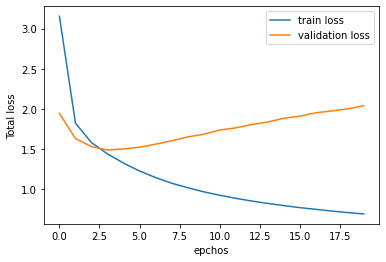

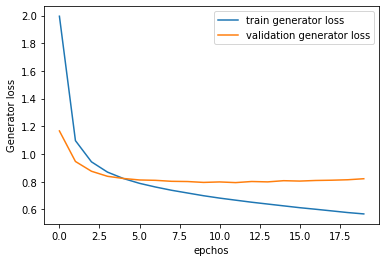

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(train_loss_list)),train_loss_list,label = 'train loss')
plt.plot(range(len(valid_loss_list)),valid_loss_list,label = 'validation loss')
plt.xlabel('epchos')
plt.ylabel('Total loss')
plt.legend()
plt.savefig('/content/drive/My Drive/mimic/tran_loss.png')
plt.figure()
plt.plot(range(len(train_gnt_loss_list)),train_gnt_loss_list,label = 'train generator loss')
plt.plot(range(len(valid_gnt_loss_list)),valid_gnt_loss_list,label = 'validation generator loss')
plt.xlabel('epchos')
plt.ylabel('Generator loss')
plt.legend()
plt.savefig('/content/drive/My Drive/mimic/generator_loss.png')
plt.show()
plt.figure()
plt.plot(range(len(train_clf_loss_list)),train_clf_loss_list,label = 'train num loss')
plt.plot(range(len(valid_clf_loss_list)),valid_clf_loss_list,label = 'validation num loss')
plt.xlabel('epchos')
plt.ylabel('Num loss')
plt.legend()
plt.savefig('/content/drive/My Drive/mimic/num_loss.png')
plt.show()

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [45]:

# gnt_model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# num_model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/pubmed/num_gnt_3.pt'))
# valid_loss,valid_gnt_loss,valid_num_loss = evaluate(model, valid_iterator, criterion)

# print(f'\tValid Loss: {valid_loss:.3f} | Valid gnt Loss: {valid_gnt_loss:.3f} |Valid num Loss: {valid_num_loss:.3f} |')
# gnt_model.load_state_dict(torch.load('/content/drive/My Drive/mimic/gnt.pt'))
# num_model.load_state_dict(torch.load('/content/drive/My Drive/mimic/num.pt'))
# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


<All keys matched successfully>

In [46]:

INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
OUTPUT_TRG_DIM = len(TEXT_NUM.vocab)
OUTPUT_DIM_NUM = len(num_vocab.stoi)
HID_DIM = 256
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              output_num_dim = OUTPUT_DIM_NUM,
              output_trg_dim = OUTPUT_TRG_DIM
              )

print(INPUT_DIM)
print(OUTPUT_DIM)
num_model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
num_model.load_state_dict(torch.load('/content/drive/My Drive/pubmed/num_2.pt'))
# valid_loss,valid_gnt_loss,valid_num_loss = evaluate(num_model, valid_iterator, criterion)

# print(f'\tValid Loss: {valid_loss:.3f} | Valid gnt Loss: {valid_gnt_loss:.3f} |Valid num Loss: {valid_num_loss:.3f} |')
# gnt_model.load_state_dict(torch.load('/content/drive/My Drive/mimic/gnt.pt'))
# num_model.load_state_dict(torch.load('/content/drive/My Drive/mimic/num_gnt.pt'))
# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

119453
119453


<All keys matched successfully>

Compute ROUGE score on validation set.

In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge
import numpy as np

rouge1_scores = []
rouge2_scores = []
rougel_scores = []
rouge = Rouge()
for example_idx in range(len(valid_data.examples)):
    src = vars(valid_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(valid_data.examples[example_idx])['LABEL']
    translation, attention,translation_num = translate_sentence_1(src, TEXT, TEXT,TEXT_NUM, model,num_model, device)
    reference = ' '.join(trg)
    prediction = ' '.join(translation)
    try:
        scores = rouge.get_scores(prediction, reference)
        rouge1_scores.append(scores[0]['rouge-1']['f'])
        rouge2_scores.append(scores[0]['rouge-2']['f'])
        rougel_scores.append(scores[0]['rouge-l']['f'])
    except:
        continue
print('ROUGE-1 score:{},std: {}'.format(np.mean(np.array(rouge1_scores)),np.std(np.array(rouge1_scores))))
print('ROUGE-2 score:{},std: {}'.format(np.mean(np.array(rouge2_scores)),np.std(np.array(rouge2_scores))))
print('ROUGE-l score:{},std: {}'.format(np.mean(np.array(rougel_scores)),np.std(np.array(rougel_scores))))
print(len(rouge1_scores))

ROUGE-1 score:0.2737419356285745,std: 0.0714037536859245
ROUGE-2 score:0.05180507939234062,std: 0.030940660765852196
ROUGE-l score:0.23973757850381971,std: 0.056193260987697745
2500


In [ ]:
from rouge import Rouge
import numpy as np

rouge1_scores = []
rouge2_scores = []
rougel_scores = []
rouge = Rouge()
for example_idx in range(len(test_data.examples)):
    src = vars(test_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(test_data.examples[example_idx])['LABEL']
    translation, attention,_ = translate_sentence_1(src, TEXT, TEXT,TEXT_NUM, model,num_model, device)
    reference = ' '.join(trg)
    prediction = ' '.join(translation)
    try:
        scores = rouge.get_scores(prediction, reference)
        rouge1_scores.append([scores[0]['rouge-1']['f'],example_idx])
        rouge2_scores.append([scores[0]['rouge-2']['f'],example_idx])
        rougel_scores.append([scores[0]['rouge-l']['f'],example_idx])

    except:
        continue
def takeScore(elem):
    return elem[0]
rouge1_scores.sort(key = takeScore,reverse = True)
rouge2_scores.sort(key = takeScore,reverse = True)
rougel_scores.sort(key = takeScore,reverse = True)
import numpy as np
r1=np.array(rouge1_scores)
r2=np.array(rouge2_scores)
rl=np.array(rougel_scores)
np.save('/content/drive/My Drive/mimic/test_1.npy',r1)
np.save('/content/drive/My Drive/mimic/test_2.npy',r2)
np.save('/content/drive/My Drive/mimic/test_l.npy',rl)
print('ROUGE-1 score:{},std: {}'.format(np.mean(np.array(rouge1_scores)[:,0]),np.std(np.array(rouge1_scores)[:,0])))
print('ROUGE-2 score:{},std: {}'.format(np.mean(np.array(rouge2_scores)[:,0]),np.std(np.array(rouge2_scores)[:,0])))
print('ROUGE-l score:{},std: {}'.format(np.mean(np.array(rougel_scores)[:,0]),np.std(np.array(rougel_scores)[:,0])))
print(len(rouge1_scores))

ROUGE-1 score:0.2768405686194151,std: 0.06988043868227586
ROUGE-2 score:0.053069464916635174,std: 0.03177017912675388
ROUGE-l score:0.24079455949464126,std: 0.05733536033957205
2500


In [ ]:
print(len(valid_data.examples))

4031


## Inference



In [ ]:
def translate_sentence_1(sentence, src_field,trg_field ,trg_num_field, gnt_model,num_model, device, max_len = 500):
    
    #model.eval()
    gnt_model.eval()
    num_model.eval()  
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = gnt_model.make_src_mask(src_tensor)
    src_mask_num = num_model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = gnt_model.encoder(src_tensor, src_mask)
        enc_src_num = num_model.encoder(src_tensor, src_mask_num)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    trg_with_num_idx = [trg_num_field.vocab.stoi[trg_num_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = gnt_model.make_trg_mask(trg_tensor)
        trg_mask_num = num_model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention, _ = gnt_model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            _, attention,output_num = num_model.decoder(trg_tensor, enc_src_num, trg_mask_num, src_mask_num)
        
        pred_token_with_num = output.argmax(2)[:,-1].item()
        trg_with_num_idx.append(pred_token_with_num)
        pred_num = output_num.argmax(2)[:,-1].item()
        if pred_token_with_num ==trg_num_field.vocab.stoi[num_token]:
            pred_token = trg_field.vocab.stoi[num_vocab.itos[pred_num]]
            trg_indexes.append(pred_token)
        else:

            pred_token = trg_field.vocab.stoi[trg_num_field.vocab.itos[pred_token_with_num]]        
            trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    trg_num_tokens = [trg_num_field.vocab.itos[i] for i in trg_with_num_idx]
    return trg_tokens[1:], attention,trg_num_tokens[1:]

In [ ]:
r1 = np.load('/content/drive/My Drive/mimic/test_1.npy')
r2 = np.load('/content/drive/My Drive/mimic/test_2.npy')
rl = np.load('/content/drive/My Drive/mimic/test_l.npy')
print(r1[:20,1])
print('---------')
print(r2[:20,1])
print('---------')
print(rl[:20,1])

[ 425.  496.  480.  344. 2220. 1100.  713.  209.  219. 1820. 1194. 1996.
 2251.  835.  134. 1908. 1375. 1751.  685. 1725.]
---------
[ 425.  480.  496.  219. 1855.  209.  344. 1783. 1996. 2220.  971. 1375.
 1888.  122.  306.  266.  835. 1751. 2090.  536.]
---------
[ 496.  425.  480. 1996. 1543.  536. 1194.   41.  344. 1645. 1178. 1717.
 2309.  931.  514. 1100.  140.  205. 1826. 1993.]


In [ ]:
pip install word2number

  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5587 sha256=1baf7a4aae9facb30b253f1e8b8002b71111938c69359f6375abbfdf52247b3c
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number


Compute Number Recall and Precision.

In [ ]:
def tokenize_split(text):
    return text.split(' ')
def number_recall(pre,ref,n=4,threshold=0.7):
    prediction = pre
    reference = ref
    pre_num = []
    ref_num = []
    pre_toks = tokenize_split(prediction)
    ref_toks = tokenize_split(reference)
    pre_nums_count = 0
    ref_nums_count = 0
    # extract numbers in prediction
    for idx,tok in enumerate(pre_toks):
        numbers = re.findall(r'\d+[\,\d+]{1,}|\d+\.?\d+|\d+',tok)
        if(len(numbers)!=0):
            pre_nums_count += 1
            pre_num.append((numbers[0],idx))
        
    # extract numbers in reference
    for idx,tok in enumerate(ref_toks):
        numbers = re.findall(r'\d+[\,\d+]{1,}|\d+\.?\d+|\d+',tok)
        if(len(numbers)!=0):
            ref_nums_count += 1
            ref_num.append((numbers[0],idx))      
#     print('numbers in reference:{}'.format(ref_num))
#     print('')
#     print('numbers in prediction:{}'.format(pre_num))
    rec_num_count = 0
    rec_nums = []
    for r_num,r_idx in (ref_num):
        for p_num,p_idx in pre_num:
            if r_num == p_num:
                ref_info = []
                pre_info = []
                ref_info.append(ref_toks[r_idx])
                pre_info.append(pre_toks[p_idx])
                #提取两边的token
                n_gram = 1
                while n_gram<n+1 and r_idx-n_gram>=0 and p_idx-n_gram>=0:
                    ref_info.insert(0,ref_toks[r_idx-n_gram])
                    pre_info.insert(0,pre_toks[p_idx-n_gram])
                    n_gram += 1
                n_gram = 1
                while n_gram<n+1 and r_idx+n_gram<len(ref_toks) and p_idx+n_gram<len(pre_toks):
                    ref_info.append(ref_toks[r_idx+n_gram])
                    pre_info.append(pre_toks[p_idx+n_gram])
                    n_gram += 1
                if len(ref_info)==0 or len(pre_info)==0:
                    continue
                # tokens -> sentence
                rs = ' '.join(ref_info)
                ps = ' '.join(pre_info)
                # compute rouge scores and use f1 measure 
                rouge = Rouge()
                scores = rouge.get_scores(ps, rs)
                rg_f = 0
                for keys in scores[0]:
                    rg_f += scores[0][keys]['f']
                if rg_f/3>threshold:
                    rec_num_count += 1
                    rec_nums.append(r_num)
                    
                    break
    if ref_nums_count==0:
        rec_rate = False
    else:
        rec_rate = rec_num_count/ref_nums_count
    if pre_nums_count==0:
        pre_rate = False
    else:
        pre_rate = rec_num_count/pre_nums_count
    return rec_rate,pre_rate

In [ ]:
from rouge import Rouge
import numpy as np
num_rec_scores = []
num_pre_scores = []
rouge = Rouge()
for example_idx in range(len(valid_data.examples)):
    src = vars(valid_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(valid_data.examples[example_idx])['LABEL']
    translation, attention,translation_num = translate_sentence_1(src, TEXT, TEXT,TEXT_NUM, model,num_model, device)
    reference = ' '.join(trg)
    prediction = ' '.join(translation)
    # try:
    #     scores = number_recall(prediction,reference)
    #     if scores is False:
    #         continue
    #     num_rec_scores.append(scores)
    # except:
    #     continue
    scores,pre= number_recall(prediction,reference)
    if scores is False:
        a=1
    else:
        num_rec_scores.append(scores)
    if pre is False:
        a=1
    else:
        num_pre_scores.append(pre)
print('Number recall score:{}'.format(np.mean(np.array(num_rec_scores))))
print('Number recall score std:{}'.format(np.std(np.array(num_rec_scores))))
print('Number precision score:{}'.format(np.mean(np.array(num_pre_scores))))
print('Number precision score std:{}'.format(np.std(np.array(num_pre_scores))))


Number recall score:0.0007832620649784641
Number recall score std:0.0100937860543068
Number precision score:0.0009931311330351057
Number precision score std:0.015890399706717583


In [ ]:
from rouge import Rouge
import numpy as np
num_rec_scores = []
num_pre_scores = []
rouge = Rouge()
for example_idx in range(len(test_data.examples)):
    src = vars(test_data.examples[example_idx])['INPUT_TEXT']
    trg = vars(test_data.examples[example_idx])['LABEL']
    translation, attention,translation_num = translate_sentence_1(src, TEXT, TEXT,TEXT_NUM, model,num_model, device)
    reference = ' '.join(trg)
    prediction = ' '.join(translation)
    # try:
    #     scores = number_recall(prediction,reference)
    #     if scores is False:
    #         continue
    #     num_rec_scores.append(scores)
    # except:
    #     continue
    scores,pre= number_recall(prediction,reference)
    if scores is False:
        a=1
    else:
        num_rec_scores.append(scores)
    if pre is False:
        a=1
    else:
        num_pre_scores.append(pre)
print('Number recall score:{}'.format(np.mean(np.array(num_rec_scores))))
print('Number recall score std:{}'.format(np.std(np.array(num_rec_scores))))
print('Number precision score:{}'.format(np.mean(np.array(num_pre_scores))))
print('Number precision score std:{}'.format(np.std(np.array(num_pre_scores))))


Number recall score:0.0014524469042907966
Number recall score std:0.013887445052118778
Number precision score:0.0016510204560863527
Number precision score std:0.01943979012798799
